In [1]:
import numpy as np
import pickle
import matplotlib as mpl
mpl.use('TkAgg')
sys.path.append(os.environ['rapp'])
sys.path.append(os.environ['raco'])
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
csfont = {'fontname':'DejaVu Serif'}
ticklabelsize = 6
plt.rcParams['xtick.labelsize'] = ticklabelsize
plt.rcParams['ytick.labelsize'] = ticklabelsize
%matplotlib inline
import sys, os
from azav_util import plot_azav
from common import get_widest_range_file, strip_dirname, get_dict, rms
from derivs import drad, dth
from get_parameter import get_parameter

In [2]:
# Make function to flip array with AZ array with either even or odd symmetry
def symmetrize_field(field, sym):
    nt, nr = np.shape(field)
    new_field = np.copy(field)
    # "Fold" the field in half
       
    # Field is ordered from theta=pi (south pole) to theta=0 (north pole)
    # Average the Northern and Southern hemispheres together (must flip 
    # the Southern hemisphere with respect to latitude, then add or subtract it
    if sym=='even':
        new_field = 0.5*(new_field + np.flip(new_field, axis=0))
    elif sym=='odd':
        new_field = 0.5*(new_field - np.flip(new_field, axis=0))
  
    return new_field

In [3]:
# Get Rachel's solar data
di = get_dict('/mizar/loma3853/fixedflux/paperplots/gongdata/avgong.pkl')
Om = di['om']*1e-9*(2*np.pi) # nHz --> rad/s
rsun = 6.957e10
rr = di['rr']*rsun
tt = di['tt']
cost_2d = di['cost_2d']
sint_2d = di['sint_2d']
rr_2d = di['rr_2d']*rsun
cost = np.cos(tt)
sint = np.sin(tt)

In [4]:
rr

array([6.96193947e+10, 6.96020022e+10, 6.95832183e+10, 6.95603298e+10,
       6.95294407e+10, 6.94894379e+10, 6.94397650e+10, 6.93787521e+10,
       6.93034078e+10, 6.92087926e+10, 6.90872538e+10, 6.89275210e+10,
       6.87120628e+10, 6.84282867e+10, 6.80789062e+10, 6.76584251e+10,
       6.71572428e+10, 6.65714634e+10, 6.58996955e+10, 6.51402694e+10,
       6.42911675e+10, 6.33503029e+10, 6.23150317e+10, 6.11827799e+10,
       5.99502082e+10, 5.86137686e+10, 5.71694258e+10, 5.56124492e+10,
       5.39370644e+10, 5.21369407e+10, 5.02045644e+10, 4.81366657e+10,
       4.59567593e+10, 4.36766721e+10, 4.12993261e+10, 3.88242342e+10,
       3.62477788e+10, 3.35640465e+10, 3.07658715e+10, 2.78460882e+10,
       2.48004527e+10, 2.16318175e+10, 1.83538183e+10, 1.50028401e+10,
       1.16941604e+10, 8.69896323e+09, 6.25519871e+09, 4.31282518e+09,
       2.70508335e+09, 1.29888581e+09, 0.00000000e+00])

In [5]:
# Let's remove the r-values lower than 4.176 x 10^10 cm
ircut = np.argmin(np.abs(rr - 3.4e10))
rr = rr[:ircut]
cost_2d = cost_2d[:, :ircut]
sint_2d = sint_2d[:, :ircut]
rr_2d = rr_2d[:, :ircut]
Om = Om[:, :ircut]
rr

array([6.96193947e+10, 6.96020022e+10, 6.95832183e+10, 6.95603298e+10,
       6.95294407e+10, 6.94894379e+10, 6.94397650e+10, 6.93787521e+10,
       6.93034078e+10, 6.92087926e+10, 6.90872538e+10, 6.89275210e+10,
       6.87120628e+10, 6.84282867e+10, 6.80789062e+10, 6.76584251e+10,
       6.71572428e+10, 6.65714634e+10, 6.58996955e+10, 6.51402694e+10,
       6.42911675e+10, 6.33503029e+10, 6.23150317e+10, 6.11827799e+10,
       5.99502082e+10, 5.86137686e+10, 5.71694258e+10, 5.56124492e+10,
       5.39370644e+10, 5.21369407e+10, 5.02045644e+10, 4.81366657e+10,
       4.59567593e+10, 4.36766721e+10, 4.12993261e+10, 3.88242342e+10,
       3.62477788e+10])

In [6]:
# And the r-values over 6.93e10 (note that at 6.94e10, my quartic CZ-RZ reference state gives nans...)
#ircut = np.argmin(np.abs(rr - 6.93e10))
#rr = rr[ircut+1:]
#cost_2d = cost_2d[:, ircut+1:]
#sint_2d = sint_2d[:, ircut+1:]
#rr_2d = rr_2d[:, ircut+1:]
#Om = Om[:, ircut+1:]
#nr = len(rr)
#rr

In [7]:
# specific L
L = (rr_2d*sint_2d)**2*Om

In [8]:
Om0 = 2.87e-6 # sideral Carrington

In [9]:
# Let's extend these arrays to the Southern hemisphere (keeping them even about the equator)
nt = len(tt)
nr = len(rr)
tt2 = np.zeros(2*nt)
tt2[:nt] = np.pi - tt[::-1]
tt2[nt:] = np.copy(tt)

cost2 = np.cos(tt2)
sint2 = np.sin(tt2)

L2 = np.zeros((2*nt, nr))
L2[:nt, :] = np.copy(L[::-1, :])
L2[nt:, :] = np.copy(L)

In [10]:
# Let's plot the result for just temperature
def plot_azav_half(fig, axis, field, radius, costheta, sintheta,
        mycmap=plt.cm.RdYlBu_r, units = r'$\rm{m}\ \rm{s}^{-1}$', 
        nlevs = 10, minmax=None, maxlat=90.,
        plotcontours=True, plotfield=True, plotlatlines=False,
        norm=None, levels=None, fsize=8, odd=True, plot_cbar=True, rvals=None):
    '''Takes a figure with a subplot (axis) of aspect ratio 1x1 and adds
    a plot of the upper meridional plane to the axis, with colorbar in the "cavity"
    of the meridional plane'''

    field = np.copy(field)
    radius = np.copy(radius)
    costheta = np.copy(costheta)
    sintheta = np.copy(sintheta)
    
    # First, "fold" the field in half, using odd symmetry
    # Please don't try this with odd N_theta!
    nt = len(costheta)
    it_half = int(nt/2)
    
    # Field is ordered from theta=pi (south pole) to theta=0 (north pole)
    # Average the Northern and Southern hemispheres together(must flip the Southern hemisphere)
    # Also add the negative of the southern hemisphere, since antisymmetric
    if odd:
        field = 0.5*(field[it_half:, :] - np.flip(field[:it_half, :], axis=0))
    else:
        field = 0.5*(field[it_half:, :] + np.flip(field[:it_half, :], axis=0))
    costheta = costheta[it_half:]
    sintheta = sintheta[it_half:]
    
    if minmax is None:
        # By default, do the max/min values of the field not including lats > 75
        it_75 = np.argmin(np.abs(costheta - np.cos(np.pi/12)))
        mini, maxi = np.min(field[:it_75, :]), np.max(field[:it_75,:])
        maxabs = max(np.abs(mini), np.abs(maxi))
        mini, maxi = -maxabs, maxabs
    else:
        mini, maxi = minmax

    # Get the exponent to use for scientific notation
    extent = np.max((np.abs(mini), np.abs(maxi)))
    exp = int(np.floor(np.log10(extent)))
    divisor = 10**exp
    
    # Normalize field by divisor
    field /= divisor
    mini /= divisor
    maxi /= divisor
   
    # Get the position of the axes on the figure
    pos = axis.get_position().get_points()
    axis_left, axis_bottom = pos[0]
    axis_right, axis_top = pos[1]
    axis_width = axis_right - axis_left
    axis_height = axis_top - axis_bottom
    axis_aspect = axis_height/axis_width
   
    # Set the colorbar axis to be in the "cavity" of the meridional plane
    # The colorbar height is set by making sure it "fits" in the cavity
    chi = np.min(radius)/np.max(radius) # aspect ratio of the shell
    cavity_height = axis_height*chi
    cbaxis_aspect = 10
    cbaxis_height = 0.7*cavity_height
    cbaxis_width = cbaxis_height/cbaxis_aspect / axis_aspect
    
    cbaxis_left = axis_left + 0.1*axis_width
    cbaxis_bottom = axis_bottom + 0.1*axis_height
    
    #Modified version of Antoine Strukarek's routine
    r = radius/np.max(radius)
    n_r = len(r)
    n_t = it_half
    rtmp = r.reshape(1, n_r)
    cthtmp = costheta.reshape(n_t, 1)
    sthtmp = sintheta.reshape(n_t, 1)
    xr = np.dot(cthtmp, rtmp)
    yr = np.dot(sthtmp, rtmp)
    
    # Specify linewidths to be used in the meridional plane, one for the 
    # boundary (lw) and one for the contours (contour_lw)
    lw = 1
    contour_lw = .2
    
    # Only plot the field cutoff
    theta_lat = (90. - maxlat)*np.pi/180
    it_max = np.argmin(np.abs(costheta - np.cos(theta_lat)))
    yr = yr[:it_max+1, :]
    xr = xr[:it_max+1, :]
    field = field[:it_max+1, :]
    
    if (plotfield):
        plt.sca(axis)
        plt.pcolormesh(yr, xr, field, vmin=mini, vmax=maxi,\
                cmap=mycmap, norm=norm)
     
        if plot_cbar:
            cbaxes = fig.add_axes([cbaxis_left, cbaxis_bottom,\
                           cbaxis_width, cbaxis_height])
            cbar = plt.colorbar(cax=cbaxes)

            #fsize = 8 # fontsize for colorbar ticks and labels
            cbaxes.tick_params(labelsize=fsize)
    #        cbar.set_label(units, rotation=270, labelpad=25, fontsize=18)
            cbar.ax.tick_params(labelsize=fsize)   #font size for the ticks
            ticks = np.array([mini, 0, maxi])
            ticklabels = []
            for i in range(len(ticks)):
                ticklabels.append(str(round(ticks[i],1)))
            ticks = np.array(ticks)
            cbar.set_ticks(ticks)
            cbar.set_ticklabels(ticklabels)

            # Put the units and exponent to left of colorbar
            cbar_label = (r'$\times10^{%i}\ $' %exp) + units
            fig.text(cbaxis_left - 0.3*cbaxis_width, cbaxis_bottom + cbaxis_height/2, cbar_label,\
                ha='right', va='center', rotation=90, fontsize=fsize)

    # Plot the boundary of the meridional plane
    plt.sca(axis)
    plt.plot(r[0]*sintheta[:it_max+1], r[0]*costheta[:it_max+1], 'k', linewidth=lw) # outer boundary
    plt.plot(r[n_r-1]*sintheta[:it_max+1], r[n_r-1]*costheta[:it_max+1], 'k', linewidth=lw) # inner boundary
    plt.plot([r[n_r-1]*sintheta[it_max], r[0]*sintheta[it_max]], [r[n_r-1]*costheta[it_max],\
                                                                  r[0]*costheta[it_max]], 'k', linewidth=lw) # polar "edge"
    plt.plot([r[n_r-1], r[0]], [0,0], 'k', linewidth=lw) # equatorial "edge"

    # Plot latitude lines, if desired
    if plotlatlines:
        lats_to_plot = np.arange(-75, 90, 15)
        for lat in lats_to_plot:
            theta_val = (90 - lat)*np.pi/180
            x_in, z_in = r[-1]*np.sin(theta_val), r[-1]*np.cos(theta_val)
            x_out, z_out = r[0]*np.sin(theta_val), r[0]*np.cos(theta_val)
            plt.sca(axis)
            plt.plot([x_in, x_out], [z_in, z_out], 'k',\
                    linewidth=contour_lw)
    if not rvals is None:
        for rval in rvals: 
            plt.sca(axis)
            rval /= np.max(radius)
            # "dimensional" rval (in dimensions of ro!)
            plt.plot(rval*sintheta[:it_max+1], rval*costheta[:it_max+1], 'k', linewidth=lw) # r value

    # Set axis ranges to be just outside the boundary lines
    lilbit = 0.01
    axis.set_xlim((-lilbit, 1 + lilbit))
    axis.set_ylim((-lilbit, 1 + lilbit))
    axis.axis('off') 

    if (plotcontours):
        if levels is None:
            levs=mini+np.linspace(1,nlevs,nlevs)/float(nlevs)*(maxi-mini)
        else: # the caller specified specific contour levels to plot!
            levs=np.array(levels)
        plt.contour(yr,xr,field,colors='k',levels=levs, linewidths=contour_lw)

In [11]:
print(np.shape(Om))
print(np.shape(L2))

(49, 37)
(98, 37)


/home5/loma3853/miniconda3/envs/custom/lib/python3.7/site-packages/ipykernel_launcher.py:94: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


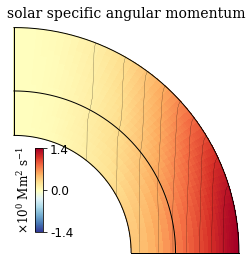

In [12]:
# Make figure
fig_width_inches = 3 + 7/16
margin_inches = 1./8.
margin_top_inches = 1./4.
margin_left_inches = 1./8.
subplot_width_inches = (fig_width_inches - 1*margin_inches - margin_left_inches)
subplot_height_inches = subplot_width_inches
fig_height_inches = 1*(subplot_height_inches + margin_inches) + margin_top_inches

fig_aspect = fig_height_inches/fig_width_inches
margin_x = margin_inches/fig_width_inches
margin_y = margin_inches/fig_height_inches
margin_top = margin_top_inches/fig_height_inches
margin_left = margin_left_inches/fig_width_inches

subplot_width = subplot_width_inches/fig_width_inches
subplot_height = subplot_height_inches/fig_height_inches
   
fig = plt.figure(figsize=(fig_width_inches, fig_height_inches))

ax1 = fig.add_axes((margin_left, 1 - margin_top - subplot_height, subplot_width, subplot_height))   
#ax2 = fig.add_axes((margin_left + 1*(subplot_width + margin_x),\
#                    1 - margin_top - subplot_height, subplot_width, subplot_height))
#ax3 = fig.add_axes((margin_left + 2*(subplot_width + margin_x),\
#                    1 - margin_top - subplot_height, subplot_width, subplot_height))

units = r'$\rm{Mm^2\ s^{-1}}$'

az_fs = 12
# Ignore NSSL
#ircut = np.argmin(np.abs(rr - 6.7e10))
ircut = 0
#plot_azav_half (fig, ax1, S_dev2[:, ircut:], rr[ircut:], cost2, sint2, fsize=az_fs,\
#               units=units_s, minmax=(-2.5e3, 2.5e3), odd=False)
#plot_azav_half (fig, ax2, P_dev2[:, ircut:], rr[ircut:], cost2, sint2, fsize=az_fs,\
#               units=units_p, minmax=None, odd=False)
plot_azav_half (fig, ax1, (L2/1e16)[:, ircut:], rr[ircut:], cost2, sint2, fsize=az_fs,\
               units=units, odd=False, rvals=[5e10], nlevs=20)


fs=14

title = 'solar specific angular momentum'
#title = r'$\langle T\rangle - \langle T\rangle_{\rm{sph}}$'
fig.text(margin_left + 0.5*subplot_width + 0*(subplot_width + margin_x), 1 - margin_top + margin_y/2,\
         title, fontsize=fs, **csfont, ha='center', va='bottom')

plt.savefig('./solar_spec_amom.png', dpi=300)

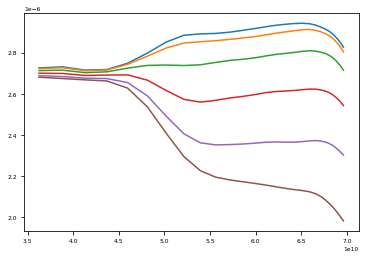

In [15]:
# magnify the tachocline region a lot
# first plot the tachocline
tt_lat = (np.pi/2 - tt)*180./np.pi
lats = [0., 15., 30., 45., 60., 75.]
for lat in lats:
    ilat = np.argmin(np.abs(tt_lat - lat))
    plt.plot(rr[ircut:], Om[ilat, ircut:])

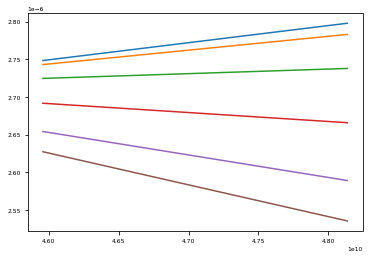

In [28]:
r1 = 4.5e10
r2 = 4.8e10
ir1 = np.argmin(np.abs(rr - r1))
ir2 = np.argmin(np.abs(rr - r2))
for lat in lats:
    ilat = np.argmin(np.abs(tt_lat - lat))
    plt.plot(rr[ir2:ir1+1], Om[ilat, ir2:ir1+1])

In [31]:
# magnify tachoclin region (between r1 and r2)
d = r2 - r1
fact = 10.
d_new = fact*d
rr_new = np.copy(rr)
for ir in range(len(rr)):
    r_loc = rr[ir]
    if r_loc >= r1 and r_loc <= r2:
        # scale these to be [fact] times further from r1 boundary
        rr_new[ir] = r1 + fact*(r_loc - r1)
    elif r_loc > r2:
        rr_new[ir] = r_loc + d_new
    # else (r_loc < r1) leave it alone!

/home5/loma3853/miniconda3/envs/custom/lib/python3.7/site-packages/ipykernel_launcher.py:94: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


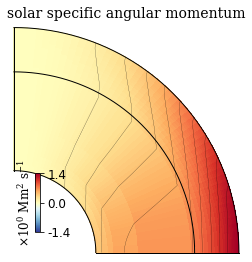

In [35]:
# Make figure
fig_width_inches = 3 + 7/16
margin_inches = 1./8.
margin_top_inches = 1./4.
margin_left_inches = 1./8.
subplot_width_inches = (fig_width_inches - 1*margin_inches - margin_left_inches)
subplot_height_inches = subplot_width_inches
fig_height_inches = 1*(subplot_height_inches + margin_inches) + margin_top_inches

fig_aspect = fig_height_inches/fig_width_inches
margin_x = margin_inches/fig_width_inches
margin_y = margin_inches/fig_height_inches
margin_top = margin_top_inches/fig_height_inches
margin_left = margin_left_inches/fig_width_inches

subplot_width = subplot_width_inches/fig_width_inches
subplot_height = subplot_height_inches/fig_height_inches
   
fig = plt.figure(figsize=(fig_width_inches, fig_height_inches))

ax1 = fig.add_axes((margin_left, 1 - margin_top - subplot_height, subplot_width, subplot_height))   
#ax2 = fig.add_axes((margin_left + 1*(subplot_width + margin_x),\
#                    1 - margin_top - subplot_height, subplot_width, subplot_height))
#ax3 = fig.add_axes((margin_left + 2*(subplot_width + margin_x),\
#                    1 - margin_top - subplot_height, subplot_width, subplot_height))

units = r'$\rm{Mm^2\ s^{-1}}$'

az_fs = 12
# Ignore NSSL
#ircut = np.argmin(np.abs(rr - 6.7e10))
ircut = 0
#plot_azav_half (fig, ax1, S_dev2[:, ircut:], rr[ircut:], cost2, sint2, fsize=az_fs,\
#               units=units_s, minmax=(-2.5e3, 2.5e3), odd=False)
#plot_azav_half (fig, ax2, P_dev2[:, ircut:], rr[ircut:], cost2, sint2, fsize=az_fs,\
#               units=units_p, minmax=None, odd=False)
plot_azav_half (fig, ax1, (L2/1e16)[:, ircut:], rr_new[ircut:], cost2, sint2, fsize=az_fs,\
               units=units, odd=False, rvals=[5e10 + d_new], nlevs=20)


fs=14

title = 'solar specific angular momentum'
#title = r'$\langle T\rangle - \langle T\rangle_{\rm{sph}}$'
fig.text(margin_left + 0.5*subplot_width + 0*(subplot_width + margin_x), 1 - margin_top + margin_y/2,\
         title, fontsize=fs, **csfont, ha='center', va='bottom')

plt.savefig('./solar_spec_amom_expanded_tach.png', dpi=300)